In [1]:
!pip -q install mat73 torcheval
!pip install -U albumentations

In [2]:
import os
import cv2
import json
import scipy.io
import shutil
import yaml
import requests
import random
import numpy as np
import torch
import torch.nn as nn
from torch.optim import Optimizer

from path import Path
from tqdm import tqdm
from PIL import Image

import matplotlib.pyplot as plt
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2, ToTensor

from torch.utils.data import Dataset, DataLoader
from torchmetrics.classification import F1Score, Accuracy, Precision, Recall
%matplotlib inline

from typing import Optional, Callable

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
ROOT_DIR = Path('/kaggle/')
INPUT_DIR = ROOT_DIR / "input"
WORKING_DIR = ROOT_DIR / "working"
DATASET_DIR = INPUT_DIR / "stanford-cars-dataset"
ANNOTATIONS_DIR = INPUT_DIR / "stanford-cars-dataset-annotations"

TRAIN_DIR = WORKING_DIR / "train"
VAL_DIR = WORKING_DIR / "val"

In [4]:
!ls $DATASET_DIR

cars_annos.mat	cars_test  cars_train


In [5]:
class StanfordCarsDataset(Dataset):
    def __init__(self, source_path: str, annotation_path: str, transforms: callable = None):
        self.source_paths = self.__load_imgs_paths(source_path)
        self.labels = self.__load_labels(annotation_path)
        self.transforms = transforms

    def __load_imgs_paths(self, path: Path) -> list[Path]:
        if not os.path.exists(path):
            raise ValueError("Not found file %s" % str(path))
        return [path / filename for filename in os.listdir(path) if os.path.isfile(path / filename)]
    
    def __load_labels(self, path: Path):
        if not os.path.exists(path):
            raise ValueError("Not found file %s" % str(path))
            
        lable_mat = scipy.io.loadmat(path)
        labels = {}
        for arr in lable_mat['annotations'][0]:
            filename, label = str(arr[5][0]), int(arr[4][0,0])-1
            labels[filename] = label

        return labels
    
    @property
    def features_amount(self) -> int:
        return len(set(self.labels))

    def __len__(self):
        return len(self.source_paths)

    def __getitem__(self, index):
        img_path = self.source_paths[index]
        img = Image.open(img_path).convert('RGB')
        label = self.labels[os.path.basename(img_path)]
    
        if self.transforms:
            img = self.transforms(image=np.array(img))['image']
            img = img.to(torch.float)
            
        return img, label

In [6]:
transform = A.Compose([
    A.Resize(width=224, height=224),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    ToTensorV2(),
])

test_transform = A.Compose([
    A.Resize(width=224, height=224),
    ToTensorV2(),
])

In [7]:
train_dataset = StanfordCarsDataset(
    source_path=DATASET_DIR / "cars_train/cars_train",
    annotation_path=ANNOTATIONS_DIR / "cars_train_annos.mat",
    transforms=transform,
)

In [8]:
test_dataset = StanfordCarsDataset(
    source_path=DATASET_DIR / "cars_test/cars_test",
    annotation_path=ANNOTATIONS_DIR / "cars_test_annos_withlabels_eval.mat",
    transforms=test_transform,
)

In [9]:
train_image, lable = train_dataset[0]
test_image, lable = test_dataset[0]

In [10]:
test_image

tensor([[[ 56.,  41.,  40.,  ..., 110., 107., 108.],
         [ 42.,  51.,  47.,  ..., 110., 108., 108.],
         [ 38.,  65.,  88.,  ..., 109., 108., 109.],
         ...,
         [124., 116., 118.,  ..., 130., 118., 118.],
         [115., 116., 119.,  ..., 123., 121., 116.],
         [116., 113., 117.,  ..., 116., 117., 119.]],

        [[ 58.,  41.,  40.,  ...,  88.,  88.,  89.],
         [ 42.,  51.,  47.,  ...,  88.,  89.,  89.],
         [ 40.,  65.,  88.,  ...,  88.,  89.,  90.],
         ...,
         [123., 115., 117.,  ..., 131., 119., 118.],
         [114., 115., 118.,  ..., 124., 122., 116.],
         [115., 112., 116.,  ..., 117., 117., 119.]],

        [[ 44.,  28.,  30.,  ...,  81.,  81.,  82.],
         [ 30.,  41.,  35.,  ...,  80.,  82.,  82.],
         [ 27.,  55.,  77.,  ...,  79.,  82.,  83.],
         ...,
         [128., 120., 122.,  ..., 135., 123., 126.],
         [118., 120., 124.,  ..., 129., 127., 126.],
         [120., 117., 121.,  ..., 122., 125., 129.]]]

In [11]:
def display_image_grid():
    rows = 1
    cols = 2
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 6))
    for i, t in enumerate([train_dataset[random.randint(1, 1000)], test_dataset[random.randint(1, 1000)]]):
        img, label = t
        ax.ravel()[i].imshow(img.T)
        ax.ravel()[i].set_title(label)
        ax.ravel()[i].set_axis_off()
    plt.tight_layout()
    plt.show()

/tmp/ipykernel_47/2159204467.py:7: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /usr/local/src/pytorch/aten/src/ATen/native/TensorShape.cpp:3571.)
  ax.ravel()[i].imshow(img.T)


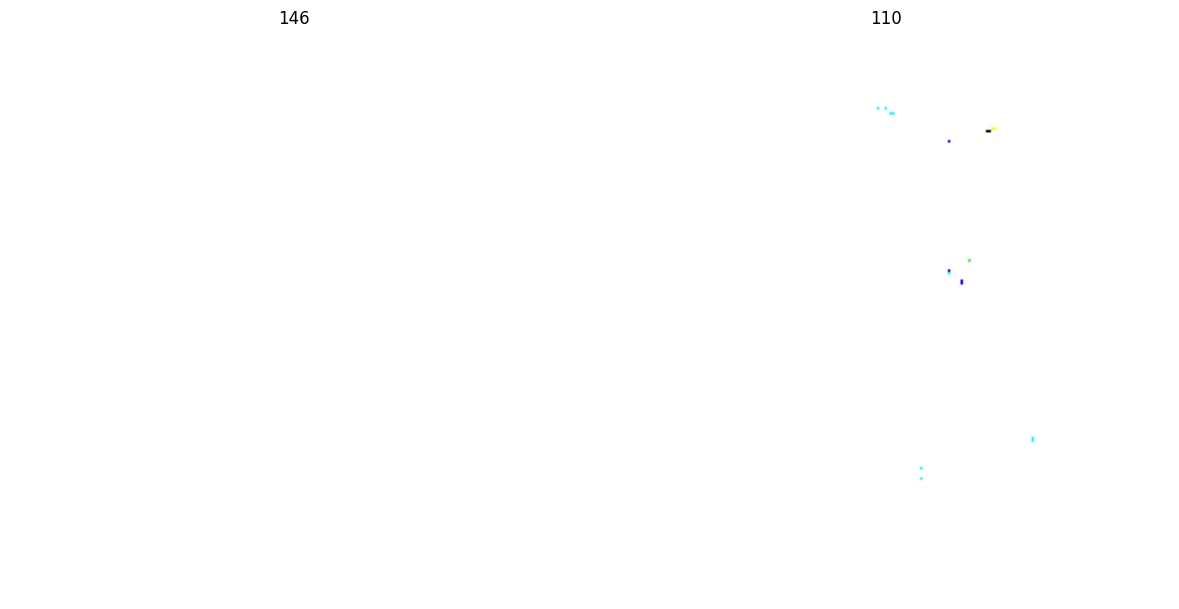

In [12]:
display_image_grid()

In [13]:
train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=32, shuffle=True)

In [14]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [15]:
class AdaSmooth(Optimizer):
    def __init__(
        self,
        params,
        learning_rate: float,
        epsilon: float,
        fast_decay: float,
        slow_decay: float,
    ):
        if learning_rate < 0.0:
            raise ValueError(
                f"Invalid learning rate: {learning_rate}. Should be >= 0.0."
            )
        if epsilon < 0.0:
            raise ValueError(f"Invalid epsilon: {epsilon}. Should be >= 0.0.")
        if fast_decay < 0.0:
            raise ValueError(f"Invalid fast_decay: {fast_decay}. Should be >= 0.0.")
        if slow_decay < 0.0:
            raise ValueError(f"Invalid slow_decay: {slow_decay}. Should be >= 0.0.")

        defaults = {
            "lr": learning_rate,
            "eps": epsilon,
            "fast_decay": fast_decay,
            "slow_decay": slow_decay,
        }
        super().__init__(params, defaults)

    def step(self, closure: Optional[Callable[[], float]] = None) -> Optional[float]:
        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:
            for p in group["params"]:
                if p.grad is None:
                    continue

                var = p.data
                grad = p.grad.data

                state = self.state[p]

                if len(state) == 0:
                    state["step"] = 0
                    state["sum_delta"] = torch.zeros_like(var)
                    state["sum_abs_delta"] = torch.zeros_like(var)
                    state["norm"] = torch.zeros_like(grad)

                sum_delta, sum_abs_delta, norm = (
                    state["sum_delta"],
                    state["sum_abs_delta"],
                    state["norm"],
                )
                state["step"] += 1

                er = torch.zeros_like(sum_delta)
                mask = sum_abs_delta != 0
                er[mask] = torch.abs(sum_delta)[mask] / sum_abs_delta[mask]

                smoothing = (group["slow_decay"] - group["fast_decay"]) * er + (
                    1 - group["slow_decay"]
                )
                smoothing_sqr = smoothing ** 2

                norm = smoothing_sqr * grad ** 2 + (1 - smoothing_sqr) * norm

                delta = -group["lr"] * grad / torch.sqrt(norm + group["eps"])
                sum_delta.add_(delta)
                sum_abs_delta.add_(abs(delta))

                var.add_(delta)
        return loss


In [16]:
def depthwise_block1(in_c1, k1, iterations, dep_stride=2):
    in_c = in_c1
    k = k1
    init = nn.Sequential()

    for i in range(iterations):
        init.add_module("some block", nn.Sequential(
            nn.Conv2d(in_c, in_c, 3, stride=dep_stride, padding=1, groups=in_c),
            nn.BatchNorm2d(num_features=in_c),
            nn.ReLU(),
            nn.Conv2d(in_c, k*in_c, 1, stride=1, padding=0),
            nn.BatchNorm2d(num_features=k*in_c),
            nn.ReLU()
        ))
        in_c = k*in_c
    return init

In [17]:
class MobileNetV1(nn.Module):
    def __init__(self, in_channels=3, in_size=(224, 224), num_classes=train_dataset.features_amount, verbouse: bool = False):
        super(MobileNetV1, self).__init__()
        
        self._verbouse = verbouse
        
        self.in_size = in_size
        self.num_classes = num_classes

        self.initial_layer = nn.Sequential(
            nn.Conv2d(in_channels, 32, 3, stride=2, padding=1),
            nn.BatchNorm2d(num_features=32),
            nn.ReLU(),
        )

#         self.depthwise_layers = nn.Sequential()

#         self.depthwise_layers.add_module("some block 1",depthwise_block1(32, 2, 1, 1))
        self.depthwise_layers1 = depthwise_block1(32, 2, 1, 1)

#         self.depthwise_layers.add_module("some block 2",depthwise_block1(64, 2, 1, 2))
        self.depthwise_layers2 = depthwise_block1(64, 2, 1, 2)

#         self.depthwise_layers.add_module("some block 3",depthwise_block1(128, 1, 1, 1))
        self.depthwise_layers3 = depthwise_block1(128, 1, 1, 1)

#         self.depthwise_layers.add_module("some block 4", depthwise_block1(128, 2, 1, 2))
        self.depthwise_layers4 = depthwise_block1(128, 2, 1, 2)

#         self.depthwise_layers.add_module("some block 5",depthwise_block1(256, 1, 1, 1))
        self.depthwise_layers5 = depthwise_block1(256, 1, 1, 1)

#         self.depthwise_layers.add_module("some block 6",depthwise_block1(256, 2, 1, 2))
        self.depthwise_layers6 = depthwise_block1(256, 2, 1, 2)

#         self.depthwise_layers.add_module("some block 7",depthwise_block1(512, 1, 5, 1))
        self.depthwise_layers7 = depthwise_block1(512, 1, 5, 1)

#         self.depthwise_layers.add_module("some block 8",depthwise_block1(512, 2, 1, 2))
        self.depthwise_layers8 = depthwise_block1(512, 2, 1, 2)

#         self.depthwise_layers.add_module("some block 9",depthwise_block1(1024, 1, 1, 2))
        self.depthwise_layers9 = depthwise_block1(1024, 1, 1, 1)
    
        self.pooling_layers = nn.AvgPool2d(kernel_size=7, stride=1)
        self.fc_layer = nn.Linear(in_features=1024, out_features=num_classes)
        self.classifier_layer = nn.Softmax()

    def forward(self, x):
        print("Input", x.shape) if self._verbouse else None
        x = self.initial_layer(x)
        print("Initial", x.shape) if self._verbouse else None
#         x = self.depthwise_layers(x)
        x =  self.depthwise_layers1(x)
        print("Depthwise 1", x.shape) if self._verbouse else None
        x =  self.depthwise_layers2(x)
        print("Depthwise 2", x.shape) if self._verbouse else None
        x =  self.depthwise_layers3(x)
        print("Depthwise 3", x.shape) if self._verbouse else None
        x =  self.depthwise_layers4(x)
        print("Depthwise 4", x.shape) if self._verbouse else None
        x =  self.depthwise_layers5(x)
        print("Depthwise 5", x.shape) if self._verbouse else None
        x =  self.depthwise_layers6(x)
        print("Depthwise 6", x.shape) if self._verbouse else None
        x =  self.depthwise_layers7(x)
        print("Depthwise 7", x.shape) if self._verbouse else None
        x =  self.depthwise_layers8(x)
        print("Depthwise 8", x.shape) if self._verbouse else None
        x =  self.depthwise_layers9(x)
        print("Depthwise 9", x.shape) if self._verbouse else None
        x = self.pooling_layers(x)
        print("Pooling", x.shape) if self._verbouse else None
        x = self.classifier_layer(x)
        print("Classifier", x.shape) if self._verbouse else None
        return x

In [19]:
acc_metric = Accuracy(task="multiclass", num_classes=train_dataset.features_amount).to(device)
re_metric = Recall(task="multiclass", num_classes=train_dataset.features_amount).to(device)
pre_metric = Precision(task="multiclass", num_classes=train_dataset.features_amount).to(device)
f1_metric = F1Score(task="multiclass", num_classes=train_dataset.features_amount).to(device)

In [32]:
def train_epoch(model: torch.nn.Module, dataloader: DataLoader, optimizer, loss_fn):
    total_loss = 0

    model.train(True)
    
    acc_metric.reset()
    re_metric.reset()
    pre_metric.reset()
    f1_metric.reset()

    for i, t in enumerate(tqdm(dataloader)):
        inputs, labels = t

        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        
        out = model(inputs)
        out = out.view(out.shape[0], -1)
        y_preds = out.argmax(dim=1)
        
        loss = loss_fn(out, labels)
        loss.backward()
        total_loss += loss.item()

        optimizer.step()
        
        
        acc_metric.update(y_preds, labels)
        re_metric.update(y_preds, labels)
        pre_metric.update(y_preds, labels)
        f1_metric.update(y_preds, labels)

    return total_loss / len(dataloader), acc_metric.compute(), re_metric.compute(), pre_metric.compute(), f1_metric.compute()

In [38]:
def validate(model, dataloader, loss_fn):
    total_loss = 0

    model.eval()

    acc_metric.reset()
    re_metric.reset()
    pre_metric.reset()
    f1_metric.reset()
    
    with torch.no_grad():
        for i, t in enumerate(tqdm(dataloader)):
            inputs, labels = t

            inputs = inputs.to(device)
            labels = labels.to(device)

            out = model.forward(inputs)
            out = out.view(out.shape[0], -1)
            y_preds = out.argmax(dim=1)
            
            loss = loss_fn(out, labels)

            total_loss += loss.item()
            
            acc_metric.update(y_preds, labels)
            re_metric.update(y_preds, labels)
            pre_metric.update(y_preds, labels)
            f1_metric.update(y_preds, labels)

    avg_vloss = total_loss / len(dataloader)

    return avg_vloss, acc_metric.compute(), re_metric.compute(), pre_metric.compute(), f1_metric.compute()

In [62]:
def train_loop(model, train_loader, test_loader, optimizer, loss_fn, prefix, epochs=10):
    best_loss = 1e10
    
    best_model = None
    storage = {
        "train": {
            "loss": [],
            "accuracy": [],
            "recall": [],
            "precision": [],
            "f1": [],
        },
        "val": {
            "loss": [],
            "accuracy": [],
            "recall": [],
            "precision": [],
            "f1": [],
        }
    }
    
    for epoch_number in range(epochs):
        print(f'\nEpoch {epoch_number+1}:')

        avg_train_loss, acc_train, re_train, pre_train, f1_train = train_epoch(model, train_loader, optimizer, loss_fn)
        print(f"Train:\nLoss: {avg_train_loss}\nAccuracy: {acc_train}\nRecall: {re_train}\nPrecision: {pre_train}\nF1: {f1_train}\n")
        storage["train"]["loss"].append(avg_train_loss)
        storage["train"]["accuracy"].append(acc_train)
        storage["train"]["recall"].append(re_train)
        storage["train"]["precision"].append(pre_train)
        storage["train"]["f1"].append(f1_train)
        
        
        
        avg_val_loss, acc_val, re_val, pre_val, f1_val = validate(model, test_loader, loss_fn)
        print(f"Validation:\nLoss: {avg_val_loss}\nAccuracy: {acc_val}\nRecall: {re_val}\nPrecision: {pre_val}\nF1: {f1_val}\n")
        storage["val"]["loss"].append(avg_val_loss)
        storage["val"]["accuracy"].append(acc_val)
        storage["val"]["recall"].append(re_val)
        storage["val"]["precision"].append(pre_val)
        storage["val"]["f1"].append(f1_val)


        if avg_val_loss < best_loss:
            best_loss = avg_val_loss
            best_model = model.state_dict()
            
    if best_model:
        model_path = f'{prefix}.pt'
        torch.save(best_model, model_path)
        
    return storage

In [63]:
model = MobileNetV1().to(device)
ce = torch.nn.CrossEntropyLoss().to(device)
adam = AdaSmooth(model.parameters(), learning_rate=0.01, epsilon=0.0001, fast_decay=0.5, slow_decay=0.01)
storage = train_loop(model, train_loader, test_loader, adam, ce, 'test', 5)


Epoch 1:


  0%|          | 0/255 [00:00<?, ?it/s]/tmp/ipykernel_47/1678031729.py:74: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = self.classifier_layer(x)
100%|██████████| 255/255 [01:16<00:00,  3.31it/s]


Train:
Loss: 6.931470581129486
Accuracy: 0.0012278978247195482
Recall: 0.0012278978247195482
Precision: 0.0012278978247195482
F1: 0.0012278978247195482



100%|██████████| 252/252 [00:57<00:00,  4.39it/s]


Validation:
Loss: 6.93146338349297
Accuracy: 0.0006218132330104709
Recall: 0.0006218132330104709
Precision: 0.0006218132330104709
F1: 0.0006218132330104709


Epoch 2:


100%|██████████| 255/255 [01:09<00:00,  3.65it/s]


Train:
Loss: 6.931465401368983
Accuracy: 0.0017190569778904319
Recall: 0.0017190569778904319
Precision: 0.0017190569778904319
F1: 0.0017190569778904319



100%|██████████| 252/252 [00:50<00:00,  5.03it/s]


Validation:
Loss: 6.931458564031692
Accuracy: 0.0018654395826160908
Recall: 0.0018654395826160908
Precision: 0.0018654395826160908
F1: 0.0018654395826160908


Epoch 3:


100%|██████████| 255/255 [01:09<00:00,  3.65it/s]


Train:
Loss: 6.931457646687826
Accuracy: 0.0015962672187015414
Recall: 0.0015962672187015414
Precision: 0.0015962672187015414
F1: 0.0015962672187015414



100%|██████████| 252/252 [00:50<00:00,  5.03it/s]


Validation:
Loss: 6.931449154066661
Accuracy: 0.003606516635045409
Recall: 0.003606516635045409
Precision: 0.003606516635045409
F1: 0.003606516635045409


Epoch 4:


100%|██████████| 255/255 [01:09<00:00,  3.65it/s]


Train:
Loss: 6.931452124726539
Accuracy: 0.0024557956494390965
Recall: 0.0024557956494390965
Precision: 0.0024557956494390965
F1: 0.0024557956494390965



100%|██████████| 252/252 [00:50<00:00,  5.00it/s]


Validation:
Loss: 6.931440319333758
Accuracy: 0.0037308791652321815
Recall: 0.0037308791652321815
Precision: 0.0037308791652321815
F1: 0.0037308791652321815


Epoch 5:


100%|██████████| 255/255 [01:10<00:00,  3.63it/s]


Train:
Loss: 6.931443498648849
Accuracy: 0.004420432262122631
Recall: 0.004420432262122631
Precision: 0.004420432262122631
F1: 0.004420432262122631



100%|██████████| 252/252 [00:50<00:00,  4.99it/s]


Validation:
Loss: 6.931361618496123
Accuracy: 0.005969406571239233
Recall: 0.005969406571239233
Precision: 0.005969406571239233
F1: 0.005969406571239233



In [64]:
def ploting(data, title, x_lable, y_lable, legend):
    for d in data:
        plt.plot(d)
    plt.title(title)
    plt.xlabel(x_lable)
    plt.ylabel(y_lable)
    plt.legend(legend, loc='upper left')
    plt.show()

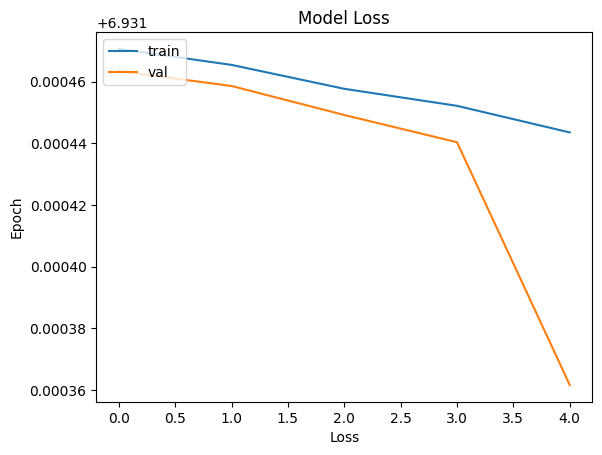

In [65]:
ploting(
    data=[storage['train']["loss"], storage['val']["loss"]],
    title='Model Loss',
    x_lable='Loss',
    y_lable='Epoch',
    legend=["train", "val"],
    
)

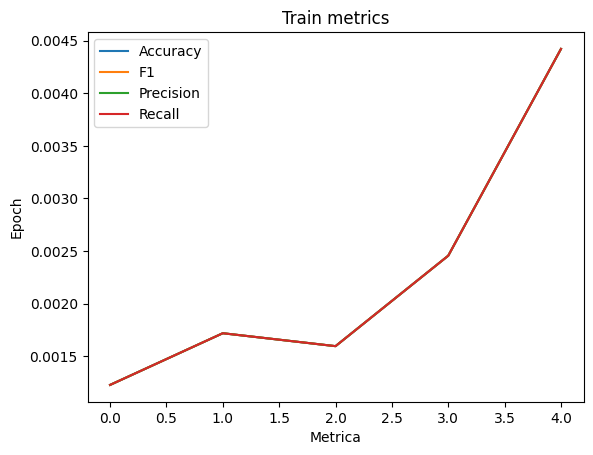

In [66]:
ploting(
    data=[
        [i.cpu() for i in storage['train']["accuracy"]], 
        [i.cpu() for i in storage['train']["f1"]], 
        [i.cpu() for i in storage['train']["precision"]], 
        [i.cpu() for i in storage['train']["recall"]],
    ],
    title="Train metrics",
    x_lable='Metrica',
    y_lable='Epoch',
    legend=["Accuracy", "F1", "Precision", 'Recall'],
)

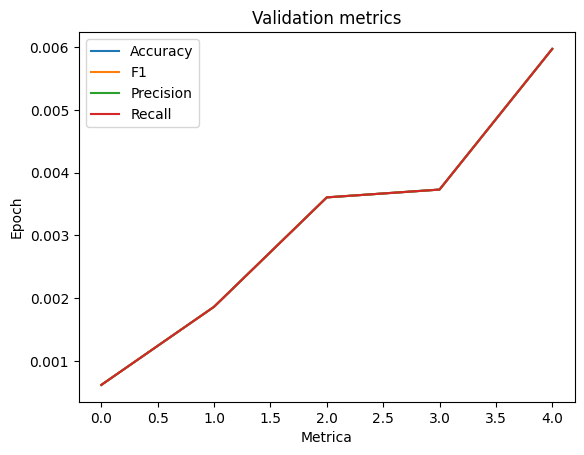

In [68]:
ploting(
    data=[
        [i.cpu() for i in storage['val']["accuracy"]], 
        [i.cpu() for i in storage['val']["f1"]], 
        [i.cpu() for i in storage['val']["precision"]], 
        [i.cpu() for i in storage['val']["recall"]],
    ],
    title="Validation metrics",
    x_lable='Metrica',
    y_lable='Epoch',
    legend=["Accuracy", "F1", "Precision", 'Recall'],
)